# REGRESIÓN LINEAL MÚLTIPLE - DATOS Boston Housing

## Realizado por: Pablo Sánchez Cabrera

Variables de las características de las casas de diferentes barrios de la ciudad de Boston:

- CRIM: Índice de criminalidad per capita
- ZN: Proporción de superficie residencial establecida en lotes mayores de 25.000 sq.ft (equivalente a 2.223 metros cuadrados).
- INDUS: Proporción de superficie de negocio no minorista.
- CHAS: Es la variable ficticia “río Charles” (igual a 1 si el tramo considerado está en la ribera del río, 0 en el otro caso)
- NOX: Concentración de óxidos de nitrógeno (partes por 10 millones)
- RM: Número promedio de habitaciones por vivienda
- AGE: Proporción de viviendas en propiedad ocupadas, construidas antes de 1940
- DIS: Distancias ponderadas a cinco centros de empleo de Boston
- RAD: Índice de accesibilidad a las autopistas radiales
- TAX: Parte del impuesto de bienes inmuebles por cada 10.000 $ de propiedad.
- PTRATIO: Ratio de alumnos por profesor
- B: Se calcula como 1000(Bk — 0.63), donde Bk es la proporción de personas de descendencia Afroamericana
- LSTAT: Porcentaje de población de “estatus de bajo nivel”
- MEDV: Mediana del valor de viviendas en propiedad (en miles de dólares)

Se cargan las librerías:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf  #sintáxis análoga a R
import scipy.stats as stats
from sklearn.preprocessing import scale #transformación de las variables - escalado (media=0, varianza=1) 

Se cargan los datos y se plantea un descriptivo:

In [15]:
datos = pd.read_csv("../data/HousingData.csv")

- `Análisis Estadístico Básico`

In [20]:
datos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Como puede verse hay registros con valores nulos, como no son muchos, por simpleza los vamos a eliminar directamente.

In [14]:
datos.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [21]:
datos = datos.dropna()
datos.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Deteción de datos anómalos

Se analizan posibles outliers para las variables `MEDV` y `RM`

In [28]:
# Detección de datos anómalos en dos variables (MEDV y RM)

media1= np.mean(datos['MEDV'])
std1 = np.std(datos['MEDV'])

outliers1 = np.mean(datos['MEDV']) + 3.0*np.std(datos['MEDV'])

media2= np.mean(datos['RM'])
std2 = np.std(datos['RM'])

outliers2 = np.mean(datos['RM']) + 3*np.std(datos['RM'])

print(f"outlier medv: {round(outliers1, 3)}")
print(f"outlier rm: {round(outliers2, 3)}")

datos_end = datos[(datos['MEDV'] <= outliers1) & (datos['RM'] <= outliers2)]

print(f"datos-ori: {datos.shape} vs datos-new: {datos_end.shape}")

outlier medv: 44.999
outlier rm: 8.13
datos-ori: (381, 14) vs datos-new: (375, 14)


Finalmente nos quedamos con **375 registros y 14 columnas**.

Todas las variables son numéricas salvo `CHAS` y `RAD`. 

In [29]:
datos = datos_end.copy()
datos['CHAS'] = datos['CHAS'].astype('category')
datos['RAD'] = pd.Categorical(datos['RAD'], ordered=True)  #ordena las categorías
datos.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.00000,375.000000
mean,3.781163,10.809333,11.085627,0.554120,6.201283,68.990133,3.822346,408.397333,18.651733,357.306400,13.20024,21.116267
std,9.402642,23.055595,6.874244,0.113688,0.595525,27.871915,2.099808,168.198983,2.082199,91.313328,7.21340,7.319334
min,0.006320,0.000000,0.740000,0.389000,3.561000,2.900000,1.137000,187.000000,12.600000,2.600000,1.98000,5.000000
25%,0.082430,0.000000,5.190000,0.453000,5.873000,45.550000,2.120350,281.000000,17.600000,376.715000,7.47000,16.500000
50%,0.259150,0.000000,8.560000,0.538000,6.167000,77.700000,3.262800,330.000000,19.100000,392.520000,11.74000,20.700000
75%,3.621175,6.250000,18.100000,0.624000,6.531500,94.300000,5.108550,666.000000,20.200000,396.900000,17.27500,24.400000
max,88.976200,100.000000,27.740000,0.871000,8.069000,100.000000,12.126500,711.000000,22.000000,396.900000,37.97000,44.000000


Podemos ver que los valores medianos y los valores medios se han visto modificados al eliminar registros nulos y hacer el pequeño tratamiento de outliers.

##  Relación entre las variables independientes y target

### 1. Relación entre las variables independientes y target

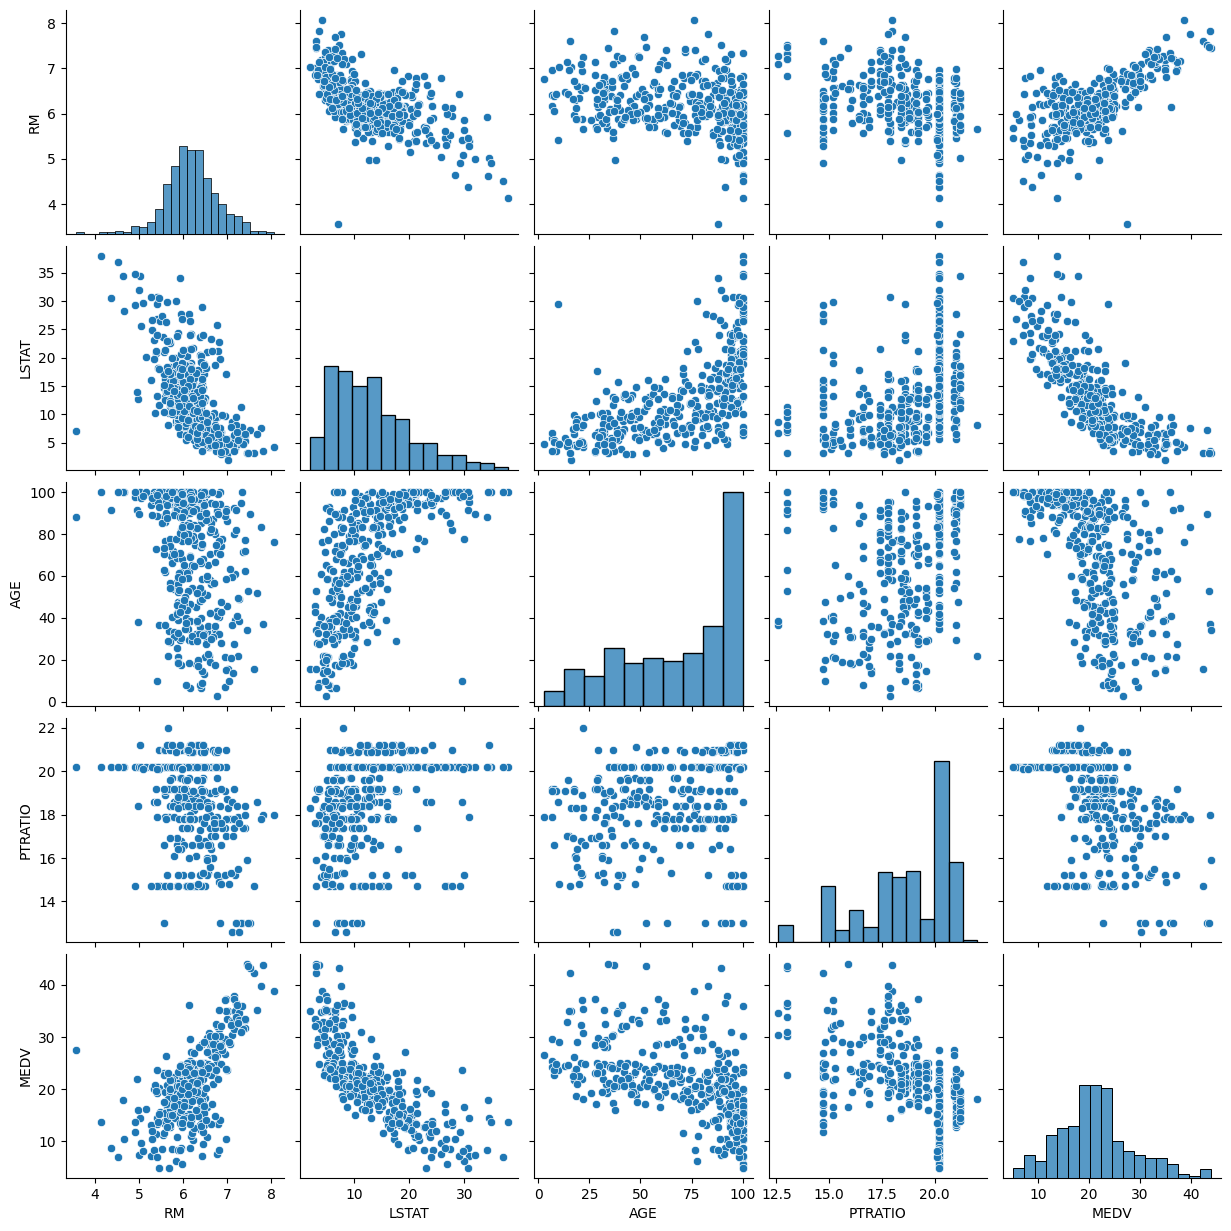

In [30]:
var_cat = ['CHAS','RAD']  #variables a eliminar en el data.frame inicial
df = datos.drop(var_cat, axis=1) #axis=1 para columnas de la matriz, axis=0 para filas (uso en índices)

# pairplot para visualizar la relación entre las variables más importantes y su distribucción
sns.pairplot(df, vars=['RM','LSTAT', 'AGE', 'PTRATIO', 'MEDV'])
plt.show() # pairplot realizado con las 4 variables que, a priori, pudieran tener más relación con target

Podemos ver una relación una fuerte relación lineal entre LSTAT y MEDV. A su vez, AGE y LST tienen una relación lineal destacable.

Con esto en mente, podemos realizar un análisis de correlación entre todas las variables numéricas:

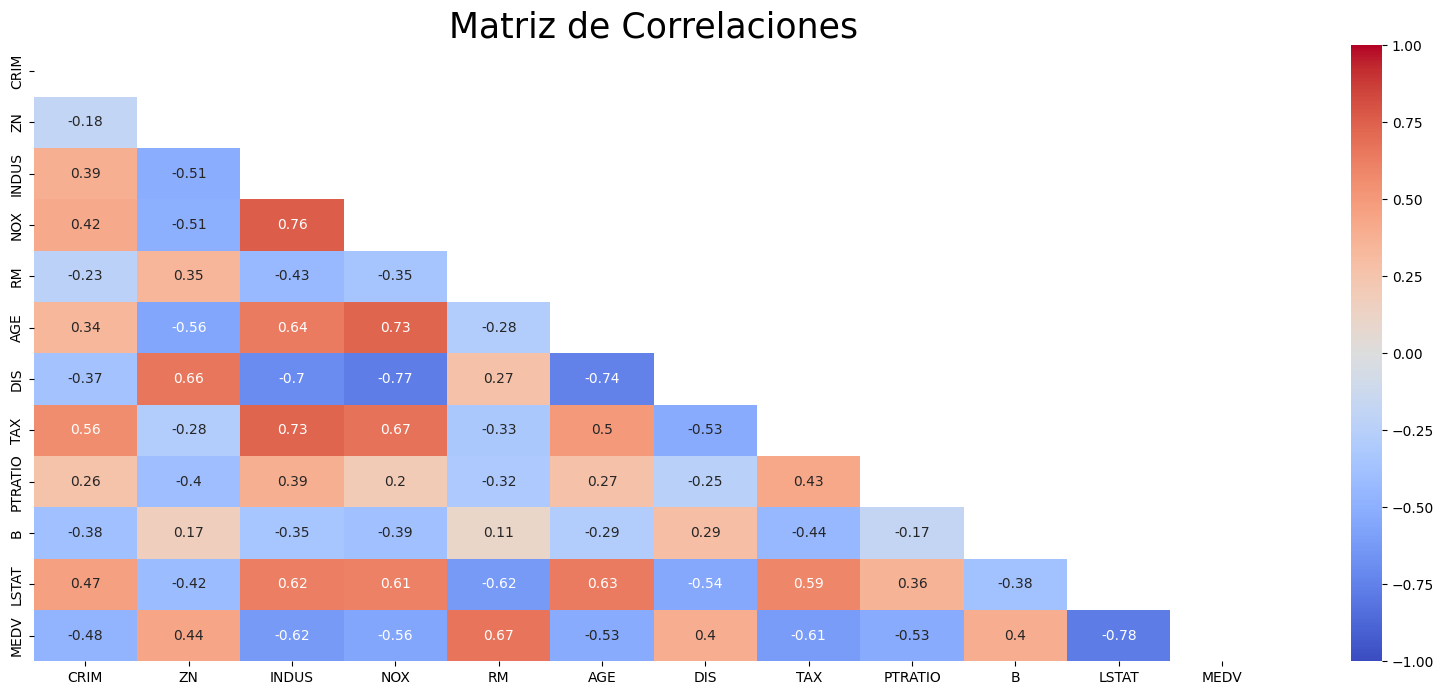

In [31]:
# Tabla de correlaciones entre variables numéricas
matriz_cor=df.corr('pearson')  # correlación de pearson

# como cor(x,x)=1 y cor(x,y)=cor(y,x) se puede disponer solo de la diagonal inferior. 
# La siguiente función elimina la parte superior de la matriz de correlaciones
mask = np.zeros(matriz_cor.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(20,8)) #tamaño del gráfico
matriz=sns.heatmap(matriz_cor, annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', mask=mask) 
# cmap para elegir la gama de colores y vmin y vmax identificar todo el espectro de valores de la correlación de pearson [-1,1]
matriz.set_title('Matriz de Correlaciones',fontsize=25)
plt.show()

A la vista está que las variables más relacionadas con la variable dependiente son: `LSTAT` y `RM`. Además se observa una fuerte relación entre DIS, NOX y AGE

### 2. Relación entre las variables categóricas

En este caso, en vez de la correlación lineal de Pearson empleamos la V de Cramer

In [32]:
df2 = datos.loc[:, var_cat] # dataframe con las variable categóricas
crosstab = pd.crosstab(df2['CHAS'], df2['RAD']) #tabla de contingencia

# Definición de V de Cramer
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

v_cramer = cramers_corrected_stat(crosstab)
print('V Cramer:', round(v_cramer,3))

V Cramer: 0.143


En base al valor, se considera que la relación entre las variables no es significativa

#### Relación con el target

- `Variable CHAS`

C:\Users\p_san\AppData\Local\Temp\ipykernel_5580\2304129626.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CHAS', y='MEDV', data=datos, palette='Set2')


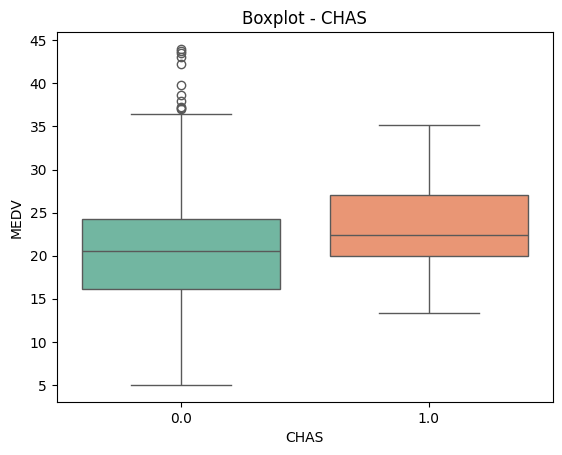

In [33]:
sns.boxplot(x='CHAS', y='MEDV', data=datos)
plt.title('Boxplot - CHAS')
plt.show()

Además del gráfico de cajas y bigotes se aplica el test de Levene

In [34]:
datos_leven = datos.loc[:, ['CHAS', 'MEDV']] #df con variable dependiente e independiente
#se divide el data.frame en las dos categorías
data1 = datos_leven.loc[datos_leven['CHAS'] == 0.0]
data2 = datos_leven.loc[datos_leven['CHAS'] == 1.0]

# Test de Igualdad de medias -> Levene
test_levene, p_value = stats.levene(data1['MEDV'], data2['MEDV'], center='mean')
print('Test Levene:', round(test_levene, 3))
print('p-value:', round(p_value, 3))

Test Levene: 1.0
p-value: 0.318


- `Variable RAD`
La variable `RAD` contiene muchas categorías diferentes y, desde un punto de vista de negocio, esto provoca pérdida de  entendimiento del modelo. Se realiza un boxplot para observar media y volatilidad de la variable dependiente según la categorí


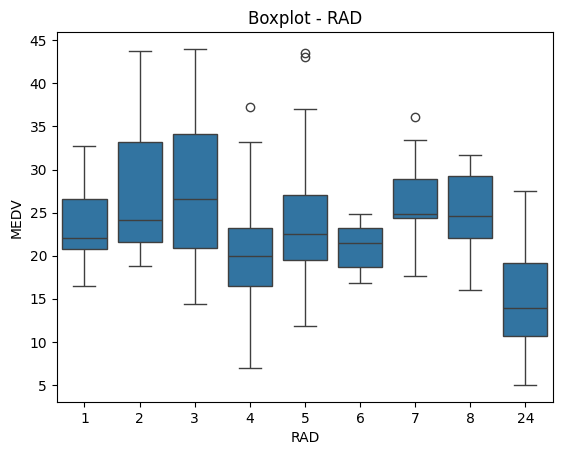

In [40]:
sns.boxplot(x='RAD', y='MEDV', data=datos)
plt.title('Boxplot - RAD')
plt.show()

En vista de los resultados se lleva a cabo un agrupamiento en 3 categorías 
- RAD_1 compuesto por: 2, 3, 5, 7 y 8
- RAD_2 compuesto por: 1, 4 y 6
- RAD_3 compuesto por: 24

In [42]:
# Definición de los grupos y condiciones
g1 = [2.0, 3.0, 5.0, 7.0, 8.0]
g2 = [1.0, 4.0, 6.0]
condiciones = [datos['RAD'].isin(g1), datos['RAD'].isin(g2)]
respuestas = ['Grupo 1', 'Grupo 2']
datos['RAD'] = np.select(condiciones,  respuestas,  default='Grupo 3' ) # Default (cláusula else)

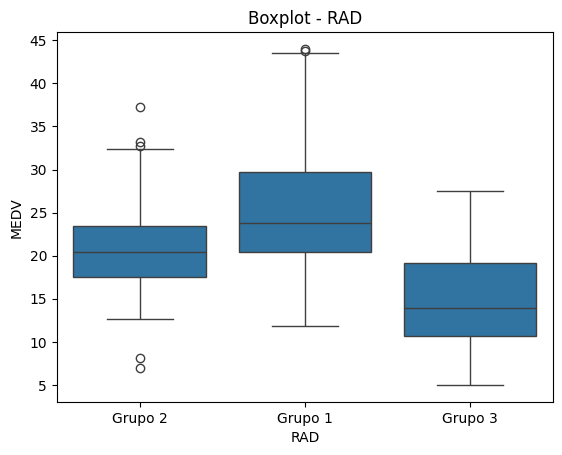

In [43]:
# Boxplot con la nueva definición de categorías
sns.boxplot(x='RAD', y='MEDV', data=datos)
plt.title('Boxplot - RAD')
plt.show()

Como en el caso anterior, se realiza el Test de Levene

In [45]:
datos_leven=datos.loc[:, ['RAD', 'MEDV']] #df con variable dependiente e independiente
#se divide el data.frame en las dos categorías
data1 = datos_leven.loc[datos_leven['RAD']=='Grupo 1']
data2 = datos_leven.loc[datos_leven['RAD']=='Grupo 2']
data3 = datos_leven.loc[datos_leven['RAD']=='Grupo 3']

# Test de Igualdad de varianzas -> Levene
test_levene, p_value =stats.levene(data1['MEDV'], data2['MEDV'], data3['MEDV'], center='mean')
print('Test Levene:', round(test_levene,3))
print('p-value:', round(p_value,3))

Test Levene: 8.2
p-value: 0.0


A la vista de los resultados se rechaza la hipótesis nula -> hay relación entre target y las variables categóricas

## Modelo de Regresión Lineal Múltiple

In [46]:
formula='MEDV ~ CRIM + ZN + CHAS + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT'
modelo = smf.ols(formula, data=datos).fit()  #ajuste del modelo
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 29 Nov 2023   Prob (F-statistic):          1.14e-118
Time:                        12:13:15   Log-Likelihood:                -975.82
No. Observations:                 375   AIC:                             1978.
Df Residuals:                     362   BIC:                             2029.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         35.3491      4.488      7.876      0.000      26.523      44.175
CHAS[T.1.0]        1.3429      0.765      1.756      0.080      -0.161       2.846
RAD[T.Grupo 2]    -1.5794      0.453     -3.487      0.001      -2.470      -0.689
RAD[T.Grupo 3]     3.1849      1.079      2.952      0.003       1.063       5.307
CRIM              -0.1050      0.024     -4.348      0.000      -0.153      -0.058
ZN                 0.0519      0.011      4.565      0.000       0.030       0.074
NOX              -15.9599      2.917     -5.471      0.000     -21.697     -10.223
RM                 2.7852      0.394      7.071      0.000       2.011       3.560
DIS               -1.1231      0.152     -7.382      0.000      -1.422      -0.824
TAX               -0.0118      0.003     -4.424      0.000      -0.017      -0.007
PTRATIO           -0.6379      0.112     -5.716      0.000      -0.857      -0.418
B                  0.0080      0.002      3.606      0.000       0.004       0.012
LSTAT             -0.3819      0.040     -9.653      0.000      -0.460      -0.304
==============================================================================
Omnibus:                       53.858   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.500
Skew:                           0.876   Prob(JB):                     1.65e-19
Kurtosis:                       4.571   Cond. No.                     1.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se ha excluido del modelo final las variables `AGE` e `INDUS` por no ser significativas (ambas tienen una alta relación con `DIS`).
Es importante que se tenga en cuenta que eliminar variables con cierta colinealidad el R-square Ajustado mejora (se incorporan en el modelo solo las variables necesarias)

La salida del modelo nos avisa de un posible problema en el modelo: multicolinealidad.

A pesar de que indica una posible multicolinealidad entre las variables independientes.
- El contraste F es significativo (al igual que el contraste para cada variable) 

Posiblemente, la causa del "warning" son las diferencias notables entre los valores de las diferentes variables independientes.
La diferente escala de las variables predictoras provoca una elevada una diferencia entre los autovalores de la matriz de covarianzas.

### Hipótesis del modelo

Para estudiar las hipótesis del modelo se obtienen los residuos

In [47]:
residuos = modelo.resid

- `Normalidad`: haciendo uso de métodos gráficos como test estadísticos

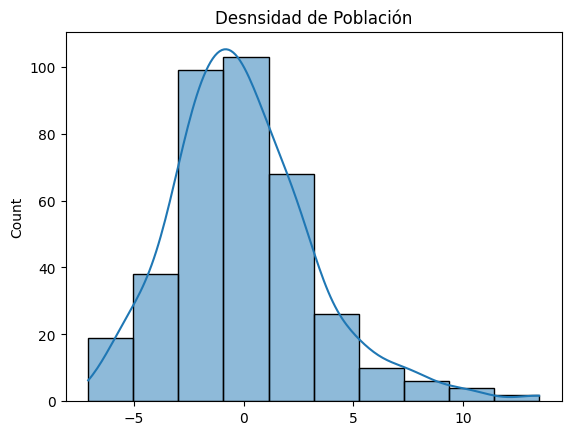

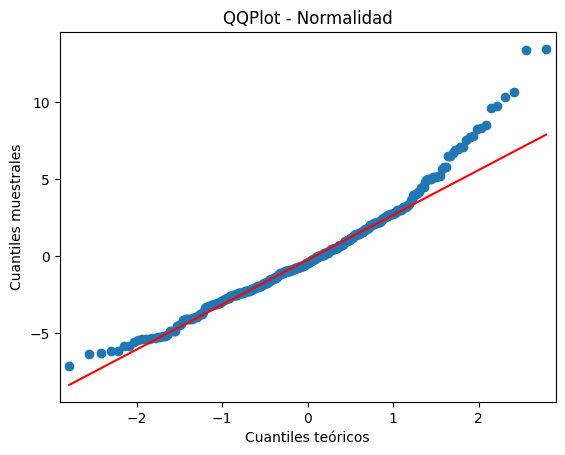

In [56]:
sns.histplot(residuos, bins=10, kde=True)
plt.title('Desnsidad de Población')
qqplot=sm.qqplot(residuos, line='q') #qqplot
qqplot=plt.title('QQPlot - Normalidad')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles muestrales')
plt.show()

In [57]:
test_normal=sm.stats.diagnostic.lilliefors(residuos)
print('Test Lilliefors: valor y p-value:', test_normal)

Test Lilliefors: valor y p-value: (0.06867623140303247, 0.0009999999999998899)


- `Homocedasticidad`: haciendo uso de métodos gráficos como test estadísticos

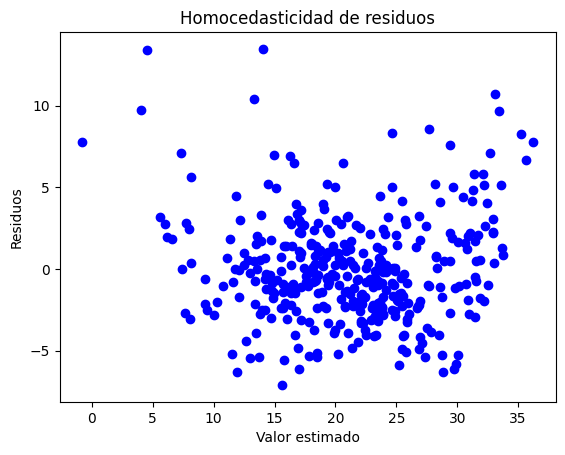

In [58]:
# Valores predichos vs residuos 
plt.plot(modelo.fittedvalues, residuos, 'bo')
plt.title('Homocedasticidad de residuos')
plt.xlabel("Valor estimado")
plt.ylabel("Residuos")
plt.show()

In [59]:
# Test Homocedasticidad -> Breusch-Pagan
test_homocedasticidad=sm.stats.diagnostic.het_breuschpagan(residuos, modelo.model.exog)
print('Test Breusch-Pagan: valor y p-value:', test_homocedasticidad[0], test_homocedasticidad[1])

Test Breusch-Pagan: valor y p-value: 34.755393335901346 0.0005122007913668576


- `No Autocorrelación`

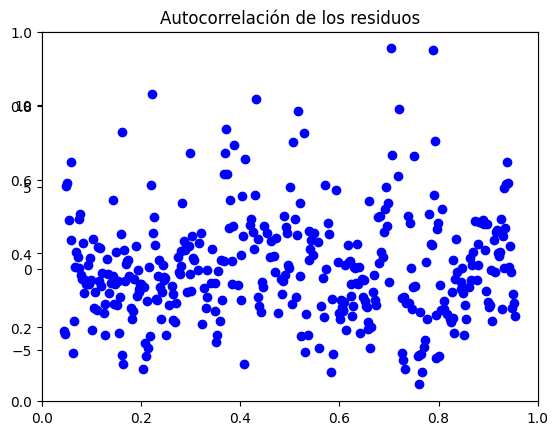

In [60]:
fig, ax1=plt.subplots()
ax1 = plt.axes(frameon=True)
ax1.axes.get_xaxis().set_visible(False) #para no mostrar ejeX
plt.plot(residuos, 'bo')
plt.title('Autocorrelación de los residuos')
plt.show()

In [62]:
test_autocorrelacion = sm.stats.diagnostic.acorr_ljungbox(residuos, lags=1)
test_autocorrelacion

,lb_stat,lb_pvalue
1,31.767879,1.737425e-08


A la vista de los resultados no se cumplen las hipótesis básicas de la regresión lineal

### Predicciones

Se pueden analizar tando las predicciones sobre la muestra de trabajo como predicciones ante nuevos datos:

- Muestra de trabajo:

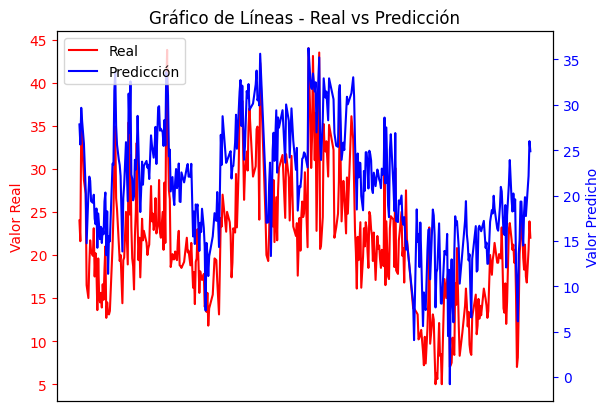

In [67]:
# Predecir con el modelo
y_pred = modelo.predict(datos)

# Crear subgráficos
fig, ax1 = plt.subplots()

# Configurar primer eje y (Real)
ax1.plot(datos['MEDV'], color='red', label='Real')
ax1.set_ylabel('Valor Real', color='red')
ax1.tick_params('y', colors='red')
ax1.axes.get_xaxis().set_visible(False)

# Configurar segundo eje y (Predicción)
ax2 = ax1.twinx()
ax2.plot(y_pred, color='blue', label='Predicción')
ax2.set_ylabel('Valor Predicho', color='blue')
ax2.tick_params('y', colors='blue')

# Añadir leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Configurar título y mostrar gráfico
plt.title('Gráfico de Líneas - Real vs Predicción')
plt.show()

- Nuevos datos

Supongamos que tenemos una nueva muestra de 3 registros como la que se tiene en el dataframe de a continuación:

In [70]:
nuevos_datos = pd.DataFrame({'CRIM': [0.0028, 0.001, 0.01],
                             'ZN': [13, 11, 14],
                             'CHAS': [1, 0, 1],
                             'NOX': [0.450, 0.538, 0.652],
                             'RM': [6.3, 7.2, 5.8], 
                             'DIS': [5.9, 6.3, 7.5],
                             'RAD': ['Grupo 1', 'Grupo 2','Grupo 3'],
                             'TAX': [250, 350, 500],'PTRATIO': [16, 18, 15],
                             'B': [390, 450, 425],
                             'LSTAT': [9.5, 8.2, 6.8]}
                           ) 
nuevos_datos

,CRIM,ZN,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.0028,13,1,0.450,6.3,5.9,Grupo 1,250,16,390,9.5
1,0.0010,11,0,0.538,7.2,6.3,Grupo 2,350,18,450,8.2
2,0.0100,14,1,0.652,5.8,7.5,Grupo 3,500,15,425,6.8


Así, obtenemos las predicciones con los intervalos de confianza y predicción

In [75]:
pred = modelo.get_prediction(nuevos_datos)

pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,27.414360,0.813946,25.813704,29.015016,20.686321,34.142399
1,23.555674,0.679443,22.219522,24.891826,16.885613,30.225735
2,23.225386,1.299782,20.669314,25.781458,16.208413,30.242359
